In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_specificity_support
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
import xgboost as xgb
pd.set_option('display.max_columns', None)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

import shap

In [2]:
def performances_hard_decision(y_test, y_proba, threshold_of_interest=0.5, youden=False):
   
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
   
    print("AUROC: {:.3f}".format(roc_auc))
   
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print("AUPRC: {:.3f}".format(pr_auc))

    
    if(youden):
        threshold_of_interest = thresholds[np.argmax(tpr - fpr)]
    
    y_pred = y_proba >= threshold_of_interest
   
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    ppv = tp / (tp+fp)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    npv = tn / (tn+fn)
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    f1 = (2 * ppv * sensitivity) / (ppv + sensitivity)
   
    print("specificity: {:.3f}".format(specificity))
    print("sensitivity: {:.3f}".format(sensitivity))
    print("PPV: {:.3f}".format(ppv))
    print("NPV: {:.3f}".format(npv))
    print("f1: {:.3f}".format(f1))
    print("accuracy: {:.3f}".format(accuracy))
    print("threshold: {:.3f}".format(threshold_of_interest))

In [3]:
def plot_roc_prc(y_hat, y):
    fpr, tpr, _ = roc_curve(y, y_hat, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y, y_hat, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

In [4]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/Asthma/data"
df_init = datatable.fread(os.path.join(DATA_PATH, 'asthma_dataset.csv'), 
                          encoding='utf-8-sig', 
                          na_strings=['', 'NA']).to_pandas()

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_init,  
                                       random_state=1004, 
                                       stratify=df_init['asthma'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

Number of samples = 759
Check their is any missing variables in dataset: 
 No                      0
date                    0
ID                      0
name                    0
age                     0
                     ... 
50.00_FEV1_90         758
50.00_FEF25_75_90     758
50.00_FVC_180         758
50.00_FEV1_180        758
50.00_FEF25_75_180    758
Length: 175, dtype: int64
Train set size = 607
Test set size = 152


## Baseline

In [5]:
import pickle
#### XGBoost
with open('../asthma_xg_classifier_baseline.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss', 'auroc', 'auprc']].reset_index(drop=True)

baseline_metric = xg_best_param.copy()

In [6]:
xg_best_param.head(1)

,max_depth,learning_rate,lambda,gamma,scores,mse_loss,auroc,auprc
0,3,0.001,2,0.3,0.868421,0.314284,0.925599,0.894715


In [7]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 2,
          'gamma': 0.3}

feature_mask = ['sp_eosinophil', 'PC20_mgpml']

X_train = train_set[feature_mask].values
y_train = train_set['asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train accuracy 0.8813838550247117
Test accuracy 0.875
Train neg_loss :  0.25977972972849644
Test neg_loss 0.32645371485207425


AUROC: 0.918
AUPRC: 0.873
specificity: 0.945
sensitivity: 0.787
PPV: 0.906
NPV: 0.869
f1: 0.842
accuracy: 0.882
threshold: 0.489
None


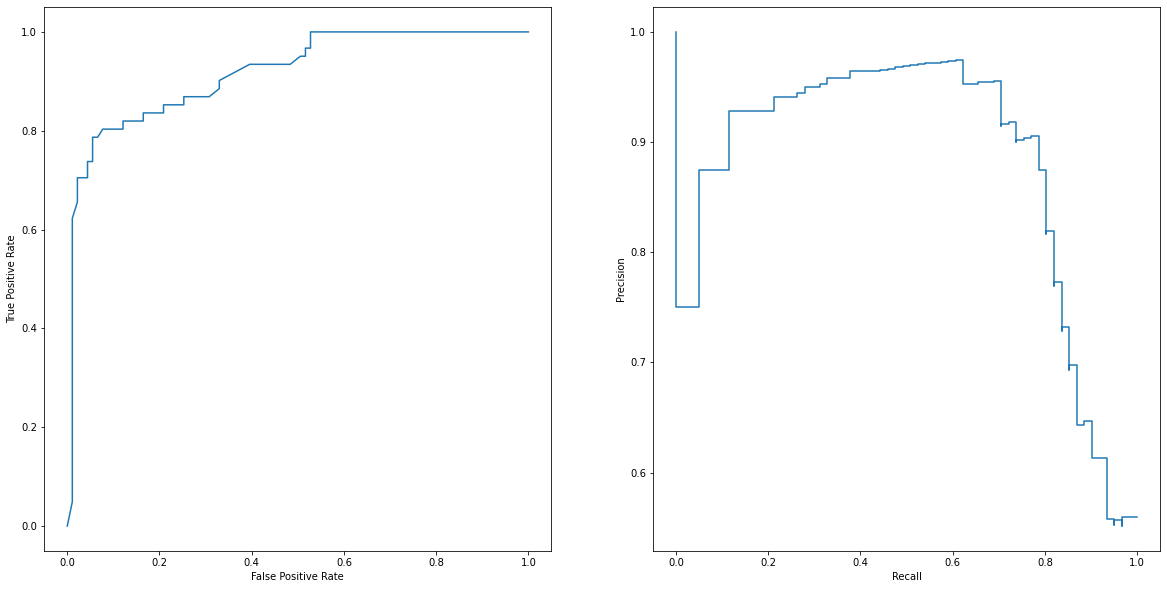

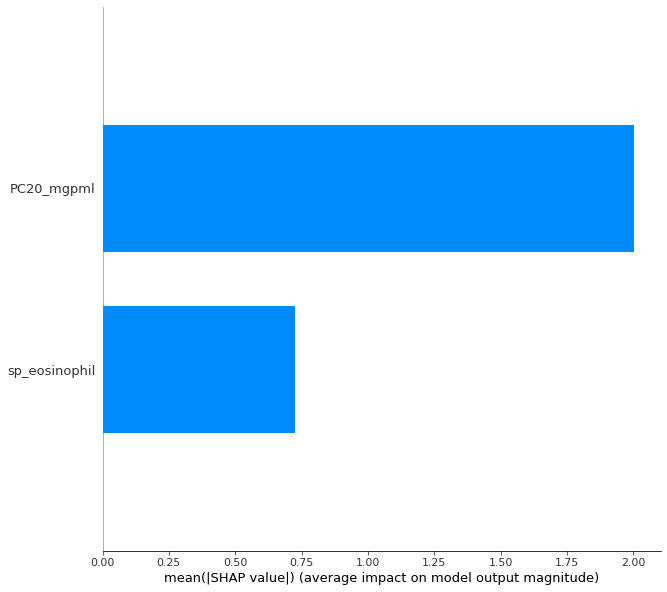

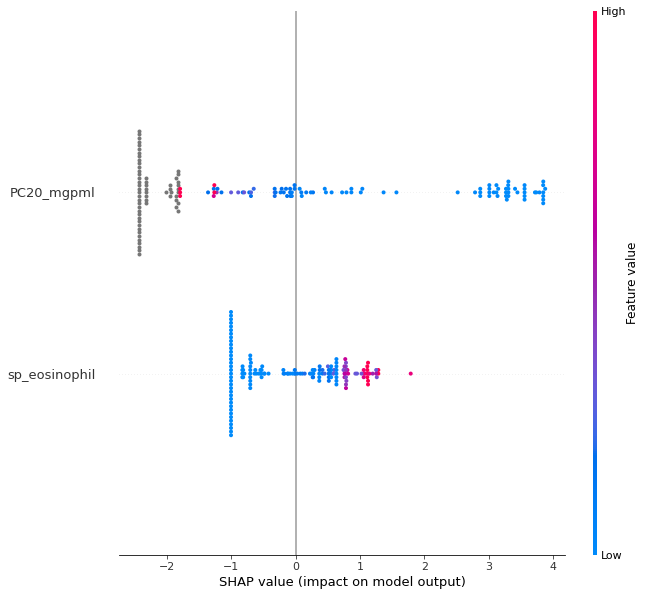

In [8]:
y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## Baseline + FeNO

In [9]:
import pickle
#### XGBoost
with open('../asthma_xg_classifier_baseline_feno.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss', 'auroc', 'auprc']].reset_index(drop=True)

baseline_feno_metric = xg_best_param.copy()

In [10]:
xg_best_param.head(1)

,max_depth,learning_rate,lambda,gamma,scores,mse_loss,auroc,auprc
0,3,0.001,3,0.0,0.875,0.325848,0.922176,0.873753


In [11]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 3,
          'gamma': 0.0}

feature_mask = ['sp_eosinophil', 'PC20_mgpml', 'FeNO']

X_train = train_set[feature_mask].values
y_train = train_set['asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train accuracy 0.8929159802306426
Test accuracy 0.881578947368421
Train neg_loss :  0.24978800439252788
Test neg_loss 0.3211038922155766


AUROC: 0.922
AUPRC: 0.887
specificity: 0.934
sensitivity: 0.820
PPV: 0.893
NPV: 0.885
f1: 0.855
accuracy: 0.888
threshold: 0.460
None


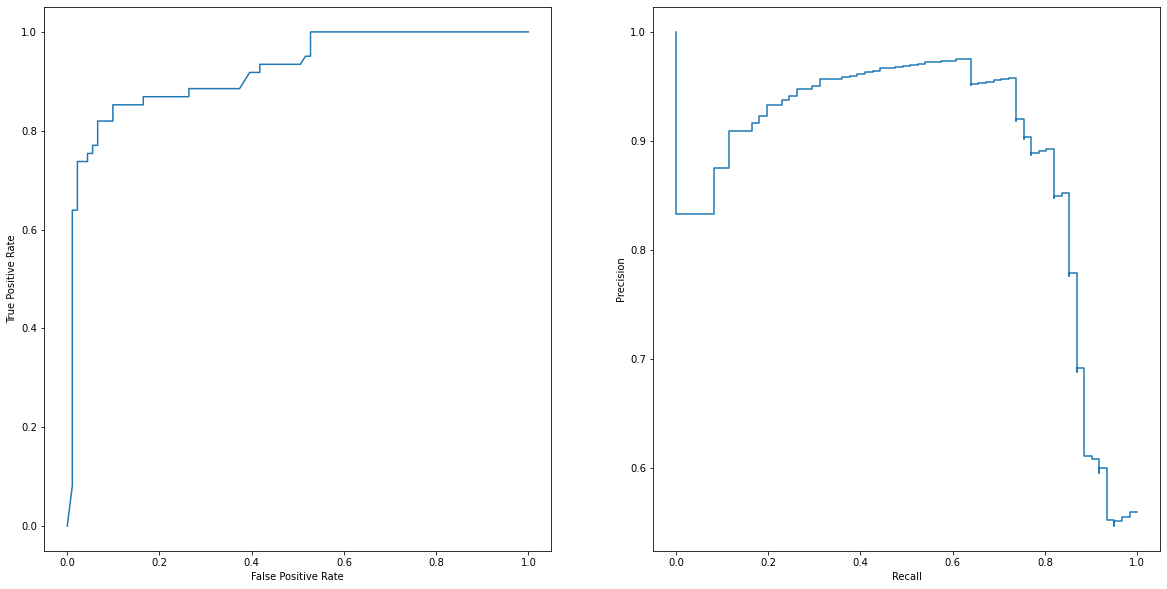

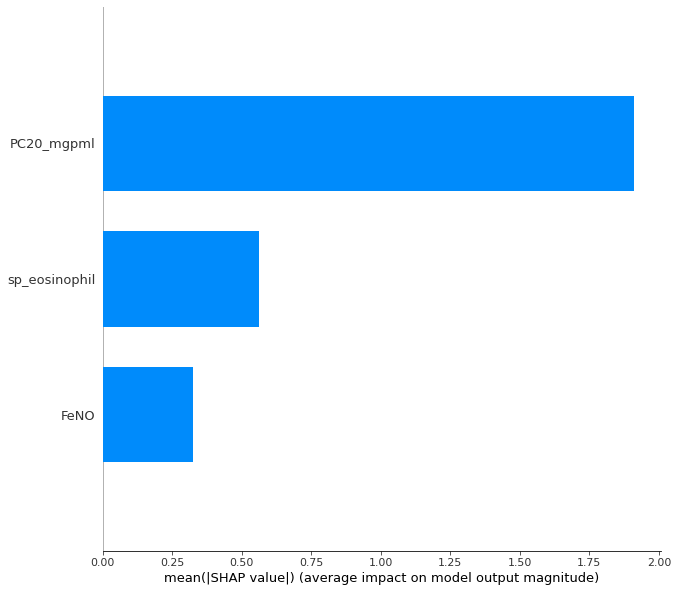

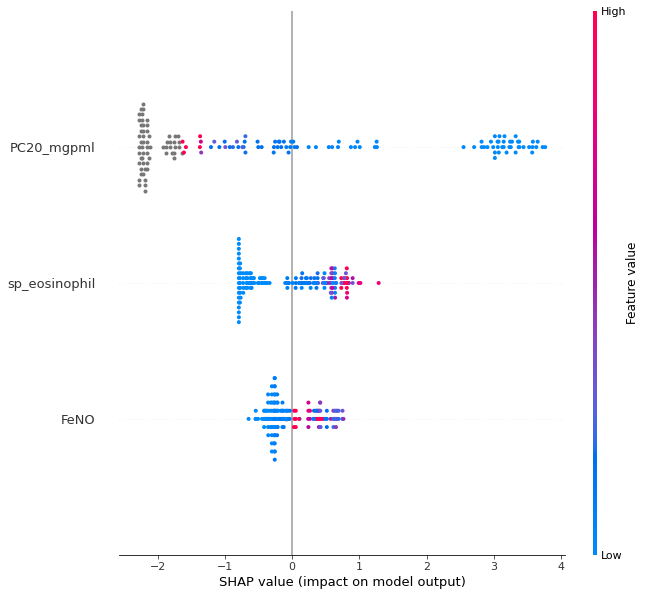

In [12]:
y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT Only

In [13]:
import pickle
#### XGBoost
with open('../asthma_xg_classifier_mbpt.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss', 'auroc', 'auprc']].reset_index(drop=True)

mbpt_metric = xg_best_param.copy()

In [14]:
xg_best_param.head(1)

,max_depth,learning_rate,lambda,gamma,scores,mse_loss,auroc,auprc
0,3,0.01,3,0.0,0.875,0.326098,0.922536,0.920161


In [15]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.01, 
          'max_depth': 3,
          'lambda': 3,
          'gamma': 0.0}

feature_mask = list(df_init.columns[82:])

X_train = train_set[feature_mask].values
y_train = train_set['asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train accuracy 0.9868204283360791
Test accuracy 0.8618421052631579
Train neg_loss :  0.11181905131926684
Test neg_loss 0.33801050875799293


AUROC: 0.921
AUPRC: 0.916
specificity: 0.890
sensitivity: 0.852
PPV: 0.839
NPV: 0.900
f1: 0.846
accuracy: 0.875
threshold: 0.358
None


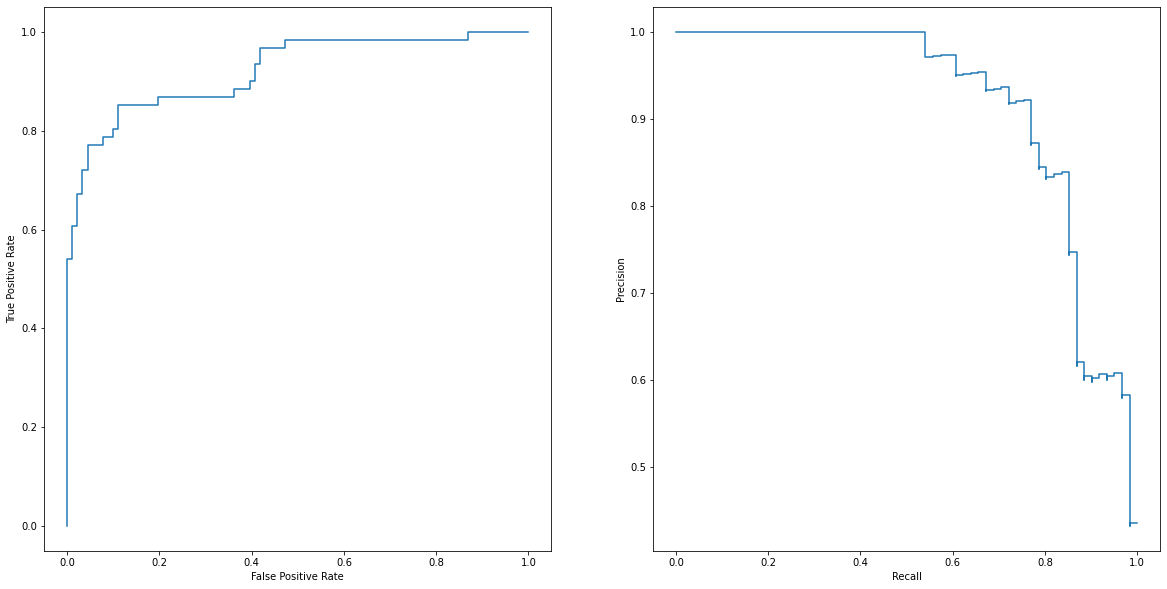

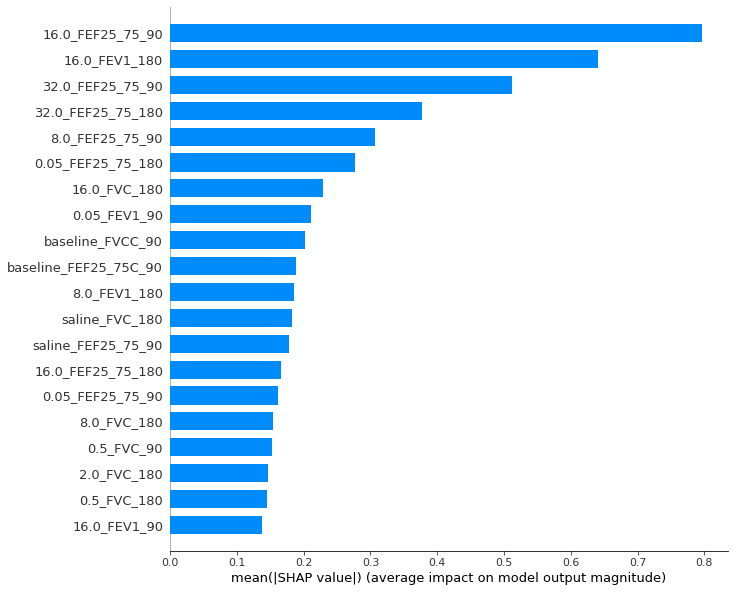

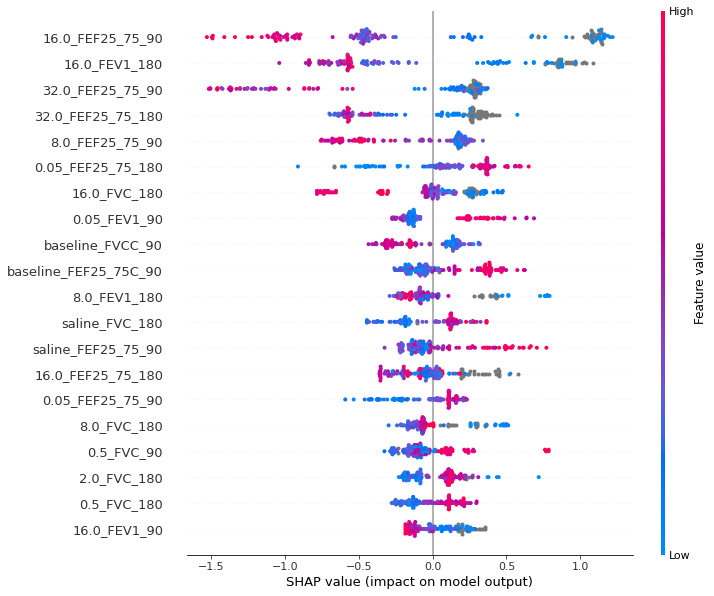

In [16]:
y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## Baseline + FeNO + MBPT

In [17]:
import pickle
#### XGBoost
with open('../asthma_xg_classifier_baseline_mbpt_feno.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['mean_mse'] == df_results_xg['mean_mse'].min()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores', 'mse_loss', 'auroc', 'auprc']].reset_index(drop=True)

baseline_mbpt_feno_metric = xg_best_param.copy()

In [18]:
xg_best_param.head(1)

,max_depth,learning_rate,lambda,gamma,scores,mse_loss,auroc,auprc
0,3,0.001,1,0.3,0.855263,0.309762,0.929382,0.914744


In [19]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 1,
          'gamma': 0.3}

feature_mask = list(df_init.columns[82:]) + ['sp_eosinophil', 'PC20_mgpml', 'FeNO']

X_train = train_set[feature_mask].values
y_train = train_set['asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

Train accuracy 0.9505766062602965
Test accuracy 0.868421052631579
Train neg_loss :  0.15643938640408722
Test neg_loss 0.31231177389149944


AUROC: 0.937
AUPRC: 0.872
specificity: 0.934
sensitivity: 0.836
PPV: 0.895
NPV: 0.895
f1: 0.864
accuracy: 0.895
threshold: 0.415
None


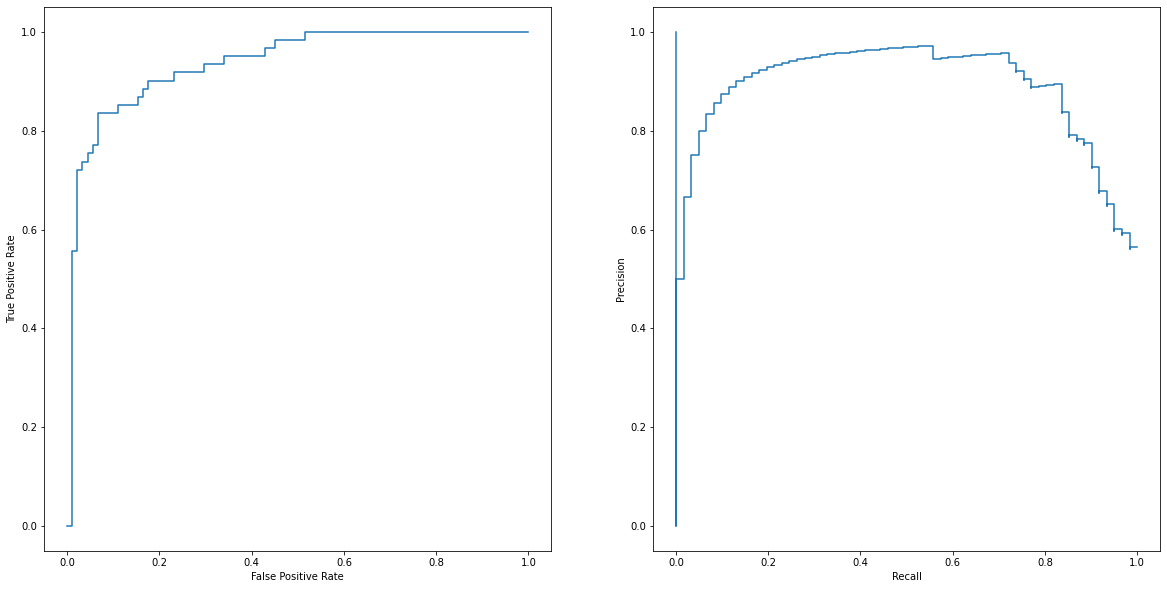

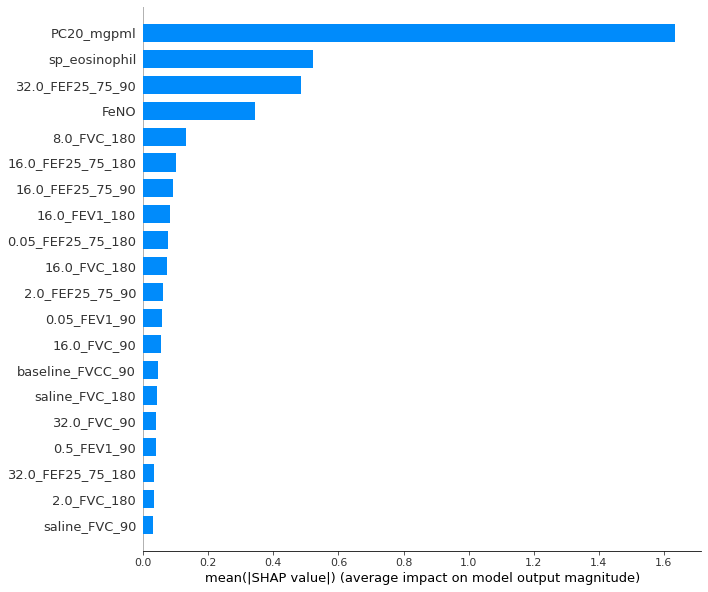

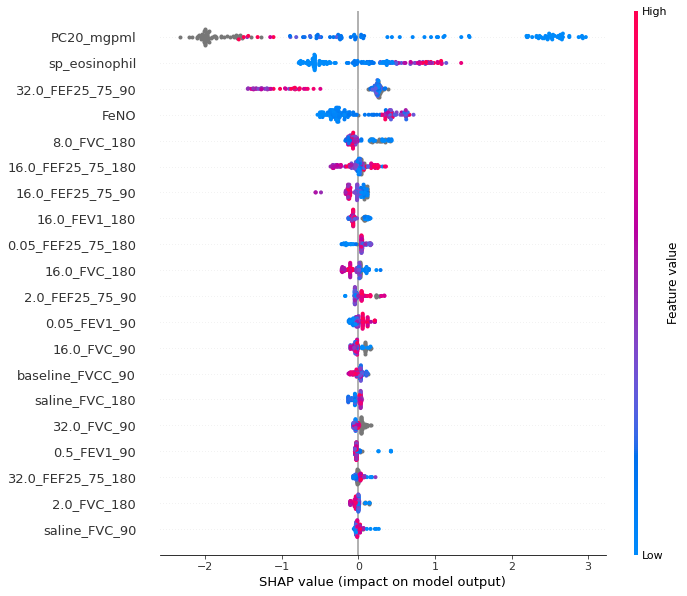

In [20]:
y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## Comparison

In [21]:
baseline_metric['variable'] = 'baseline'
baseline_feno_metric['variable'] = 'baseline_feno'
mbpt_metric['variable'] = 'mbpt_only'
baseline_mbpt_feno_metric['variable'] = 'baseline_mbpt_feno'

metrics = pd.concat([baseline_metric, baseline_feno_metric, mbpt_metric, baseline_mbpt_feno_metric], axis=0).reset_index(drop=True)

In [22]:
metrics.head()

,max_depth,learning_rate,lambda,gamma,scores,mse_loss,auroc,auprc,variable
0,3,0.001,2,0.3,0.868421,0.314284,0.925599,0.894715,baseline
1,3,0.001,2,0.3,0.881579,0.316880,0.921546,0.876386,baseline
2,3,0.001,2,0.3,0.881579,0.323989,0.916772,0.883779,baseline
3,3,0.001,2,0.3,0.875000,0.318023,0.927040,0.893750,baseline
4,3,0.001,2,0.3,0.868421,0.339909,0.920375,0.899699,baseline


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

baseline v.s. baseline_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=2.242e-01
baseline_feno v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.194e+00
mbpt_only v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=3.320e-01 stat=-2.241e+00
baseline v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.336e+00
baseline_feno v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=7.451e-01 stat=-1.718e+00
baseline v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=8.989e-01 stat=-1.593e+00


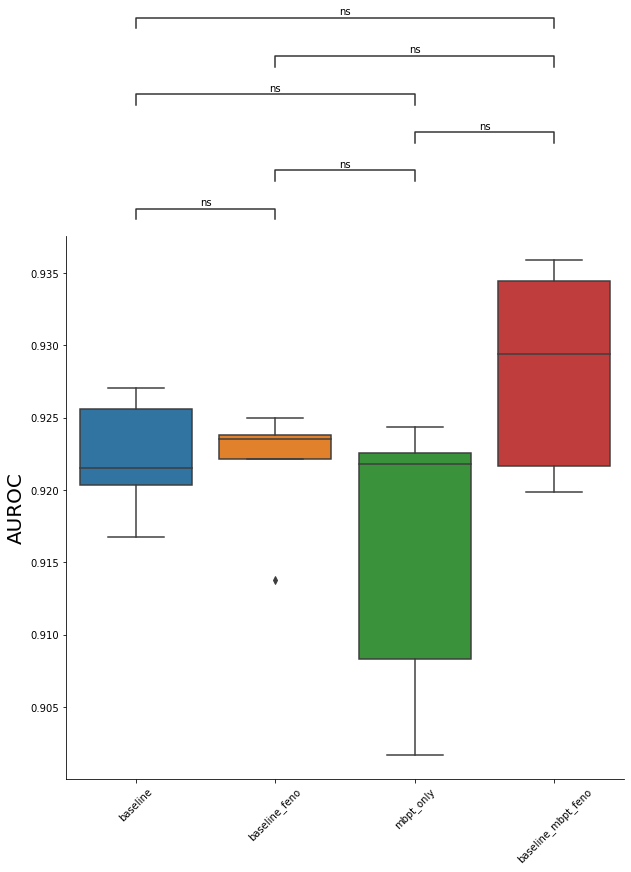

In [23]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'auroc'
order = ['baseline', 'baseline_feno', 'mbpt_only', 'baseline_mbpt_feno']
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=[('baseline', 'baseline_feno'), 
                                              ('baseline', 'mbpt_only'), 
                                              ('baseline', 'baseline_mbpt_feno'),
                                              ('baseline_feno', 'mbpt_only'),
                                              ('baseline_feno', 'baseline_mbpt_feno'),
                                              ('mbpt_only', 'baseline_mbpt_feno'), 
                                              ],
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('AUROC', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

baseline v.s. baseline_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=7.481e-01
baseline_feno v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=1.629e-02 stat=-4.273e+00
mbpt_only v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=3.945e-01 stat=2.130e+00
baseline v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=3.035e-02 stat=-3.824e+00
baseline_feno v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.091e+00
baseline v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-5.539e-01


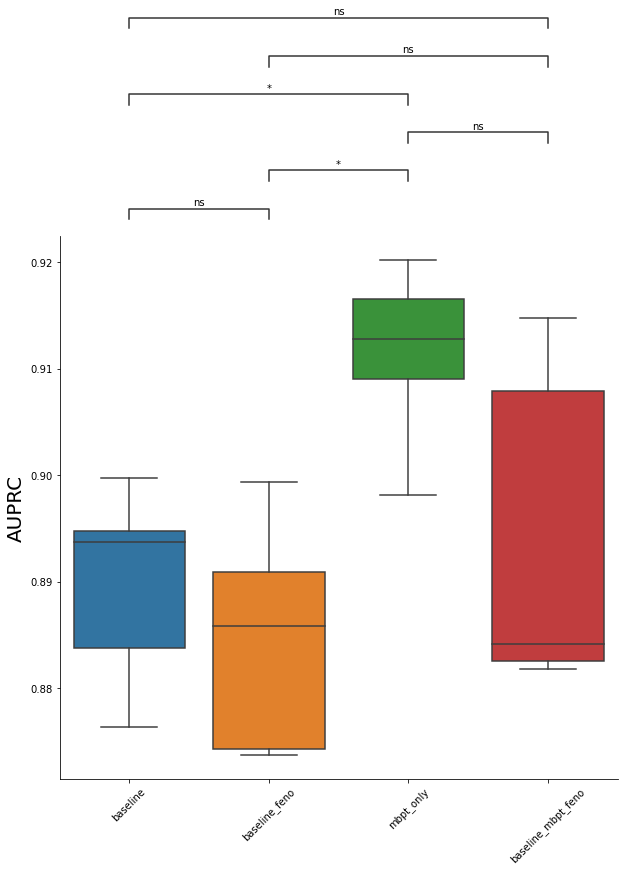

In [24]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'auprc'
order = ['baseline', 'baseline_feno', 'mbpt_only', 'baseline_mbpt_feno']
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=[('baseline', 'baseline_feno'), 
                                              ('baseline', 'mbpt_only'), 
                                              ('baseline', 'baseline_mbpt_feno'),
                                              ('baseline_feno', 'mbpt_only'),
                                              ('baseline_feno', 'baseline_mbpt_feno'),
                                              ('mbpt_only', 'baseline_mbpt_feno'), 
                                              ],
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.ylim(0.86, 0.95)
plt.xlabel("")
plt.ylabel('AUPRC', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

baseline v.s. baseline_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-6.265e-01
baseline_feno v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=6.542e-01 stat=-1.803e+00
mbpt_only v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=6.541e-02 stat=3.297e+00
baseline v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=3.992e-01 stat=-2.123e+00
baseline_feno v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=9.880e-02 stat=3.024e+00
baseline v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=4.317e-01 stat=2.072e+00


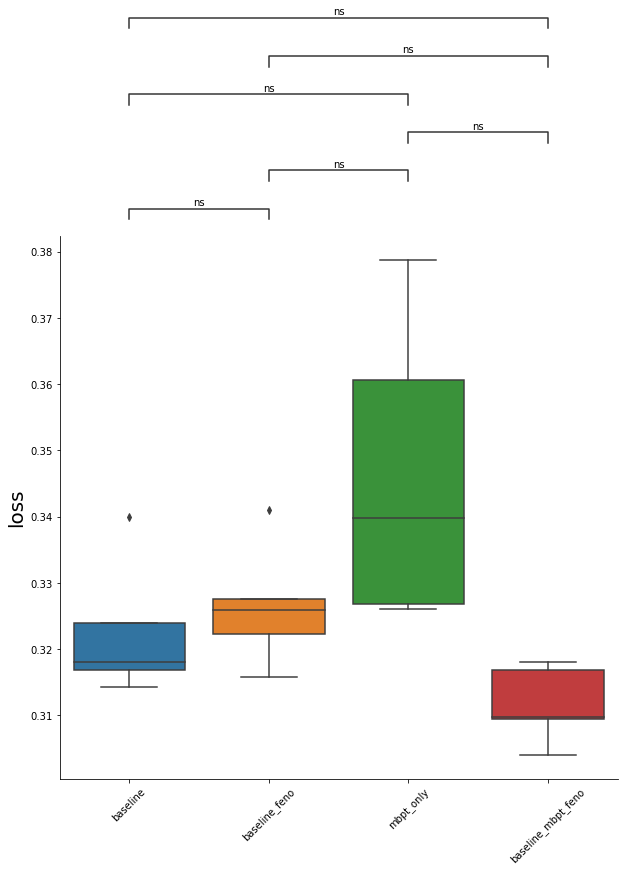

In [25]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'mse_loss'
order = ['baseline', 'baseline_feno', 'mbpt_only', 'baseline_mbpt_feno']
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=[('baseline', 'baseline_feno'), 
                                              ('baseline', 'mbpt_only'), 
                                              ('baseline', 'baseline_mbpt_feno'),
                                              ('baseline_feno', 'mbpt_only'),
                                              ('baseline_feno', 'baseline_mbpt_feno'),
                                              ('mbpt_only', 'baseline_mbpt_feno'), 
                                              ],
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.ylim(0.86, 0.95)
plt.xlabel("")
plt.ylabel('loss', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

baseline v.s. baseline_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-5.145e-01
baseline_feno v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=4.731e-01 stat=2.013e+00
mbpt_only v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=8.943e-01 stat=-1.596e+00
baseline v.s. mbpt_only: t-test independent samples with Bonferroni correction, P_val=3.898e-01 stat=2.138e+00
baseline_feno v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=3.906e-01
baseline v.s. baseline_mbpt_feno: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=0.000e+00


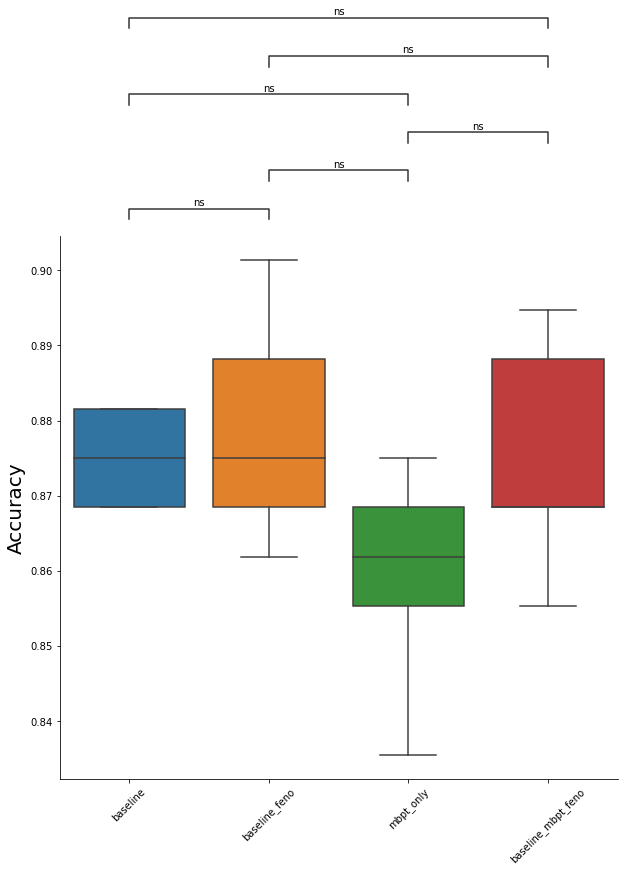

In [26]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'scores'
order = ['baseline', 'baseline_feno', 'mbpt_only', 'baseline_mbpt_feno']
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=[('baseline', 'baseline_feno'), 
                                              ('baseline', 'mbpt_only'), 
                                              ('baseline', 'baseline_mbpt_feno'),
                                              ('baseline_feno', 'mbpt_only'),
                                              ('baseline_feno', 'baseline_mbpt_feno'),
                                              ('mbpt_only', 'baseline_mbpt_feno'), 
                                              ],
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# plt.ylim(0.86, 0.95)
plt.xlabel("")
plt.ylabel('Accuracy', fontsize=20)
sns.despine()